# E 모델 먼저

In [2]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import platform

# 시스템이 Windows일 경우
if platform.system() == 'Windows':
    plt.rc('font', family='Pretendard')
# macOS일 경우 예시:
elif platform.system() == 'Darwin':
    plt.rc('font', family='AppleGothic')

# 마이너스 부호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

In [3]:
from modules.data_loader import load_and_process
from modules.feature_selector import stage_feature_map

file_path = "../../data/통합_train_데이터.parquet"
test_path = "../../data/통합_test_데이터.parquet"

stage_name = "e" # <- 변경해서 사용
save_path = "./models"

In [3]:
from modules.feature_selector import generate_e_features
from modules.feature_selector import generate_vif_derived_features

if stage_name == "e":
    # 1. 데이터 로드
    e_train, _ = load_and_process(file_path=file_path, stage=stage_name)

    # 2. 파생변수 생성
    e_train = generate_e_features(e_train)
    e_train = generate_vif_derived_features(e_train)

    # 3. 타겟 생성
    e_train["target"] = (e_train["Segment"] == 4).astype(int)

    # 4. 파생변수 포함한 전체 컬럼 기준 X/y 분리
    drop_cols = ["ID", "Segment", "target"]
    X = e_train.drop(columns=drop_cols)
    y = e_train["target"]

    # 5. used_cols 재정의
    used_cols = X.columns.tolist()

    print("📌 최종 피처 수:", len(used_cols))
    print("✅ X shape:", X.shape)
    print("✅ y 분포:\n", y.value_counts())

📂 데이터 불러오기 완료
[연회비발생카드수_B0M] 인코딩 완료
[한도증액횟수_R12M] 인코딩 완료
[이용금액대] 중간값 인코딩 완료
[할인건수_R3M] 인코딩 완료
[할인건수_B0M] 인코딩 완료
[방문횟수_PC_R6M] 인코딩 완료
[방문횟수_앱_R6M] 인코딩 완료
[방문일수_PC_R6M] 인코딩 완료
✅ 범주형 인코딩 완료
📌 최종 피처 수: 298
✅ X shape: (2400000, 298)
✅ y 분포:
 target
1    1922052
0     477948
Name: count, dtype: int64


In [4]:
from sklearn.model_selection import train_test_split

# Stratify를 적용해 클래스 비율을 유지한 채 분리
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,         # 검증셋 비율 (20%)
    random_state=42,       # 재현성 고정
    stratify=y             # 클래스 비율 유지 (불균형 대비)
)

# 확인
print("✅ 학습셋 크기:", X_train.shape, y_train.shape)
print("✅ 검증셋 크기:", X_val.shape, y_val.shape)
print("✅ 학습셋 클래스 분포:\n", y_train.value_counts(normalize=True))
print("✅ 검증셋 클래스 분포:\n", y_val.value_counts(normalize=True))

✅ 학습셋 크기: (1920000, 298) (1920000,)
✅ 검증셋 크기: (480000, 298) (480000,)
✅ 학습셋 클래스 분포:
 target
1    0.800855
0    0.199145
Name: proportion, dtype: float64
✅ 검증셋 클래스 분포:
 target
1    0.800854
0    0.199146
Name: proportion, dtype: float64


In [5]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
# XGBoost DMatrix 변환
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

if stage_name == "e":
    # GPU 기반 파라미터 설정
    best_params = {
        'max_depth': 8,
        'learning_rate': 0.2435,
        'min_child_weight': 9,
        'subsample': 0.6043,
        'colsample_bytree': 0.8550,
        'gamma': 3.3658,
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'tree_method': 'hist',   # 최신버전 기준
        'device': 'cuda',        # GPU 사용
        'use_label_encoder': False
    }

# 학습
model = XGBClassifier(**best_params, verbosity=0)
model.fit(X_train, y_train)

c:\Users\somee\anaconda3\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.855, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=3.3658, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2435, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=9, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

📋 Classification Report (Optuna Tuned):
              precision    recall  f1-score   support

           0       0.88      0.84      0.86     95590
           1       0.96      0.97      0.97    384410

    accuracy                           0.94    480000
   macro avg       0.92      0.90      0.91    480000
weighted avg       0.94      0.94      0.94    480000



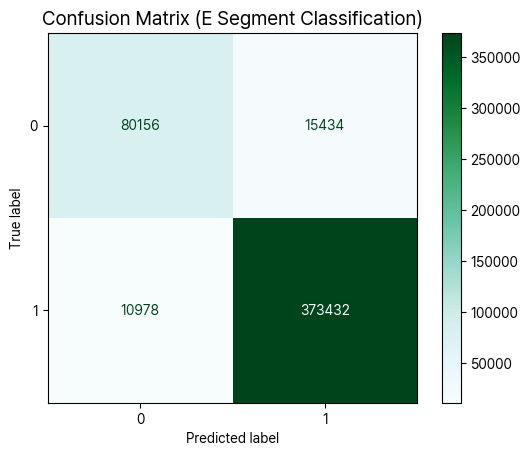

In [6]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 예측
y_pred = model.predict(X_val)

# 📋 분류 리포트
print("📋 Classification Report (Optuna Tuned):")
print(classification_report(y_val, y_pred))

# 예측값과 실제값
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# 컬러맵 적용 (예: 연초록 계열)
disp.plot(cmap='BuGn', values_format='d')  
plt.title("Confusion Matrix (E Segment Classification)", fontsize=14)
plt.show()


In [ ]:
from modules.model_utils import save_xgb_model

if stage_name=="e":
    path= "./models/model_e.pkl"
save_xgb_model(model, path)

✅ 모델 전체 저장 완료: ./models/model_e.pkl



🌟 최적 Threshold: 0.508 (F1 Score: 0.9659)
📋 Classification Report (Threshold 적용):
              precision    recall  f1-score   support

      Others       0.88      0.84      0.86     95590
           E       0.96      0.97      0.97    384410

    accuracy                           0.95    480000
   macro avg       0.92      0.91      0.91    480000
weighted avg       0.94      0.95      0.94    480000



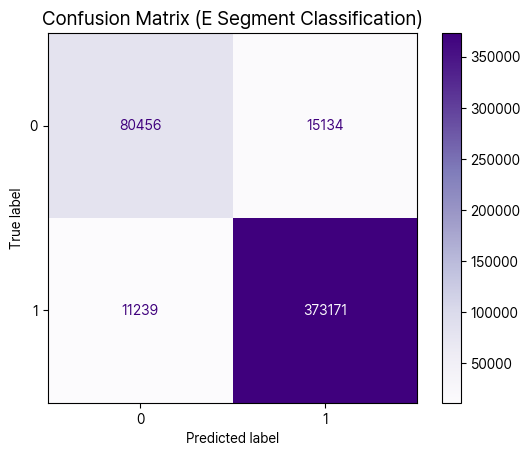

In [11]:
from modules.model_utils import apply_best_threshold

threshold, best_f1, y_pred_thresh = apply_best_threshold(model, X_val, y_val)

print("📋 Classification Report (Threshold 적용):")
print(classification_report(y_val, y_pred_thresh, target_names=["Others", "E"]))

# 예측값과 실제값
cm = confusion_matrix(y_val, y_pred_thresh)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# 컬러맵 적용
disp.plot(cmap='Purples', values_format='d')  
plt.title("Confusion Matrix (E Segment Classification)", fontsize=14)
plt.show()

In [9]:
from modules.feature_selector import generate_e_features
from modules.feature_selector import generate_vif_derived_features

In [10]:
stage_name ="e"

In [11]:
if stage_name == "e":
    # 1. 테스트 데이터 불러오기 및 가공
    e_test, _ = load_and_process(file_path=test_path, stage="e")
    e_test = generate_e_features(e_test)
    e_test = generate_vif_derived_features(e_test)

    # 3. 사용 컬럼 순서 맞추기
    X_test = e_test
    print("📌 테스트셋 shape:", X_test.shape)

📂 데이터 불러오기 완료
[연회비발생카드수_B0M] 인코딩 완료
[한도증액횟수_R12M] 인코딩 완료
[이용금액대] 중간값 인코딩 완료
[할인건수_R3M] 인코딩 완료
[할인건수_B0M] 인코딩 완료
[방문횟수_PC_R6M] 인코딩 완료
[방문횟수_앱_R6M] 인코딩 완료
[방문일수_PC_R6M] 인코딩 완료
✅ 범주형 인코딩 완료
📌 테스트셋 shape: (600000, 299)


In [12]:
from modules.model_utils import load_xgb_model

if stage_name=="e":
    path = "./models/model_e.pkl"
    e_threshold = 0.508
elif stage_name=="abcd":
    path = "./models/model_abcd.pkl"
elif stage_name == "cd":
    path = "./models/model_c_tuned.pkl"


model = load_xgb_model(path)
try:
    used_cols = model.feature_names_in_.tolist()
except AttributeError:
    used_cols = None  # 다음 단계로

✅ 모델 로드 완료: ./models/model_e.pkl


In [13]:
# ID 컬럼 제거
# 누락된 컬럼 추가 (0으로 채움)
for col in used_cols:
    if col not in X_test.columns:
        X_test[col] = 0

# 예측용 컬럼 순서 정렬
X_test = X_test[used_cols]

if "ID" in X_test.columns:
    X_test = X_test.drop(columns=["ID"])

proba_e = model.predict_proba(X_test)[:, 1]
y_pred_e = (proba_e > e_threshold).astype(int)

# 1.2 Segment E로 예측된 고객 ID만 따로 저장
e_pred_ids = e_test.loc[y_pred_e == 1, "ID"]

# 1.3 Segment E 제외한 test 데이터 추출
e_test_rest = e_test.loc[~e_test["ID"].isin(e_pred_ids)].copy()


In [14]:
e_test_rest

,RP건수_교통_B0M,이용후경과월_할부_유이자,평잔_RV일시불_3M,포인트_잔여포인트_B0M,이용금액_일시불_B0M,이용금액_할부_무이자_R3M,이용여부_3M_해외겸용_본인,방문일수_앱_R6M,잔액_할부_B2M,평잔_일시불_해외_6M,...,이용건수_신용_R6M_div_이용건수_신판_R12M,이용건수_신용_R6M_minus_이용건수_신용_R12M,이용건수_신용_R6M_div_이용건수_신용_R12M,잔액_신판최대한도소진율_r3m_minus_잔액_신판평균한도소진율_r6m,잔액_신판최대한도소진율_r3m_div_잔액_신판평균한도소진율_r6m,이용건수_신용_R6M_minus_이용건수_일시불_R12M,이용건수_신용_R6M_div_이용건수_일시불_R12M,잔액_카드론_B1M_minus_잔액_카드론_B2M,잔액_카드론_B1M_div_잔액_카드론_B2M,포인트건별_변화량
10,0,12,1103,0,3862,0,1,7,0,0,...,0.283019,-38,0.283019,0.021650,1.673499,-38,0.283019,0,NaN,0
16,1,12,0,0,17139,0,1,0,0,545,...,0.507965,-278,0.507965,0.146934,1.613911,-275,0.510676,0,NaN,2316
29,0,4,2651,0,6514,0,1,0,3798,0,...,0.497717,-220,0.497717,0.060799,1.533603,-220,0.497717,0,NaN,0
32,0,12,2604,0,1172,0,1,1,0,0,...,0.344828,-76,0.344828,0.029920,1.160273,-76,0.344828,0,NaN,0
34,2,12,4056,0,9917,0,1,0,7414,0,...,0.511879,-226,0.511879,0.010134,1.096402,-226,0.511879,0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599947,0,12,0,0,17203,0,1,51,0,267,...,0.435484,-350,0.435484,-0.051109,0.712861,-346,0.438312,0,NaN,0
599957,0,5,5088,0,12865,0,1,34,1323,0,...,0.488806,-274,0.488806,0.023663,1.197672,-274,0.488806,0,NaN,0
599961,1,12,0,0,8266,0,0,0,0,0,...,0.582278,-132,0.582278,0.031422,1.147928,-132,0.582278,0,NaN,0
599982,0,12,0,0,21254,0,1,0,0,1497,...,0.565517,-189,0.565517,0.022862,1.250082,-189,0.565517,0,NaN,0


In [15]:
from xgboost import XGBClassifier
import joblib

# 1. 모델 로드
model_abcd = XGBClassifier()
model_abcd.load_model("./models/model_abcd2.json")

# 2. 사용 컬럼 로드
used_cols = joblib.load(open("./models/model_abcd_used_cols2.pkl", "rb"))
print(f"📌 모델에 저장된 feature 수: {len(used_cols)}")

📌 모델에 저장된 feature 수: 79


In [38]:
from modules.feature_selector import selected_cols
from modules.feature_selector import stage_feature_map
from modules.data_loader import load_and_process

stage_name = "abcd"
if stage_name == "abcd":
    # 1. 테스트 데이터 불러오기 및 가공
    stage_feature_map["abcd"] = selected_cols
    ad_test, _ = load_and_process(file_path=test_path, stage="abcd")


📂 데이터 불러오기 완료
[이용금액대] 중간값 인코딩 완료
✅ 범주형 인코딩 완료


In [39]:
# e_test_rest에서 ID 리스트 추출
ad_ids = e_test_rest["ID"].values  # 또는 .tolist()

In [40]:
ad_test = ad_test[ad_test["ID"].isin(ad_ids)].copy()

In [41]:
X_ad_test = ad_test[used_cols]
print("📌 필터링 후 테스트셋 shape:", X_ad_test.shape)

📌 필터링 후 테스트셋 shape: (80832, 79)


In [42]:
import xgboost as xgb

booster = model_abcd.get_booster()  # 또는 booster = xgb.Booster(); booster.load_model("...")

dtest = xgb.DMatrix(X_ad_test)
probs = booster.predict(dtest)
preds = probs.argmax(axis=1)

In [43]:
import xgboost as xgb

# 1. booster 객체로 변환
booster = model_abcd.get_booster()  # model_abcd = XGBClassifier(); model_abcd.load_model("model_abcd.json")

# 2. DMatrix로 테스트셋 변환
dtest = xgb.DMatrix(X_ad_test)

# 3. 확률 예측 → argmax로 클래스 선택
probs = booster.predict(dtest)
preds = probs.argmax(axis=1)

# 4. 클래스 복원 (예: A/B/C/D)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(["A", "B", "C", "D"])
segment_preds = le.inverse_transform(preds)

# 5. 결과 저장
result_df = ad_test[["ID"]].copy()
result_df["Segment"] = segment_preds

In [44]:
result_df.head()

,ID,Segment
10,10,C
16,16,C
29,29,C
32,32,C
34,34,C


In [45]:
# C/D 예측된 고객
cd_result_df = result_df[result_df["Segment"].isin(["C", "D"])].copy()
cd_ids = cd_result_df["ID"].tolist()

print("📌 C/D로 예측된 고객 수:", len(cd_result_df))
print(cd_result_df.head())

📌 C/D로 예측된 고객 수: 80552
    ID Segment
10  10       C
16  16       C
29  29       C
32  32       C
34  34       C


In [46]:
ab_result_df = result_df[result_df["Segment"].isin(["A", "B"])].copy()

In [47]:
from xgboost import XGBClassifier
import joblib

# 1. 모델 로드
model_cd = XGBClassifier()
model_cd.load_model("./models/model_cd.json")

# 2. 사용 컬럼 로드
used_cols = joblib.load(open("./models/model_cd_used_cols.pkl", "rb"))
print(f"📌 모델에 저장된 feature 수: {len(used_cols)}")

📌 모델에 저장된 feature 수: 17


In [48]:
# 전체 test 데이터에서 C/D 예측된 ID만 필터링
cd_test = ad_test[ad_test["ID"].isin(cd_ids)].copy()

In [49]:
used_cols

['정상청구원금_B5M',
 '이용금액_R3M_신용체크',
 '정상입금원금_B5M',
 '최대이용금액_일시불_R12M',
 '이용가맹점수',
 '이용금액_오프라인_R6M',
 '평잔_일시불_6M',
 '잔액_신판ca평균한도소진율_r6m',
 'RV일시불이자율_할인전',
 '오프라인_소비급등비율',
 '일시불_최근성지표',
 '소비_평균대최대비율',
 '청구_최근성지표',
 '소진율_차이',
 '카드집중도',
 '입금청구비율',
 '일시불_금액비율']

In [50]:
from modules.feature_selector import selected_cols
from modules.feature_selector import stage_feature_map
from modules.data_loader import load_and_process
from modules.feature_selector import generate_cd_derived_features

stage_name = "cd"
if stage_name == "cd":
    # 1. 테스트 데이터 불러오기 및 가공
    cd_test, _ = load_and_process(file_path=test_path, stage="cd")
    cd_test = generate_cd_derived_features(cd_test)
    
    # 3. 사용 컬럼 순서 맞추기
    X_cd_test = cd_test[used_cols]
    print("📌 테스트셋 shape:", X_ad_test.shape)


📂 데이터 불러오기 완료
[이용금액대] 중간값 인코딩 완료
✅ 범주형 인코딩 완료
📌 테스트셋 shape: (80832, 79)


In [51]:
import xgboost as xgb

booster = model_abcd.get_booster()  # 또는 booster = xgb.Booster(); booster.load_model("...")

dtest = xgb.DMatrix(X_ad_test)
probs = booster.predict(dtest)
preds = probs.argmax(axis=1)

In [52]:
import xgboost as xgb

# 1. booster 객체로 변환
booster = model_abcd.get_booster()  # model_abcd = XGBClassifier(); model_abcd.load_model("model_abcd.json")

# 2. DMatrix로 테스트셋 변환
dtest = xgb.DMatrix(X_ad_test)

# 3. 확률 예측 → argmax로 클래스 선택
probs = booster.predict(dtest)
preds = probs.argmax(axis=1)

# 4. 클래스 복원 (예: A/B/C/D)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(["A", "B", "C", "D"])
segment_preds = le.inverse_transform(preds)

# 5. 결과 저장
result_df = ad_test[["ID"]].copy()
result_df["Segment"] = segment_preds